# Web Search Engine Bias

## Libraries:

In [242]:
# Necessary libraries
import numpy as np
import pandas as pd
import re
import time
import csv
import re
from collections import OrderedDict

# Selenium web scrapping 
from selenium import webdriver 
from webdriver_manager.chrome import ChromeDriverManager

from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys

# Rank-Biased Overlap analysis
import rbo
# Jaccard-Needham dissimilarity 
import distance
# Kendall’s tau
import scipy.stats as stats

# Graphs
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

import plotly.express as px
import plotly.graph_objects as go

## Functions:

In [3]:
# function start Chrome driver with login a user in a Google Account and a Chrome 
# ERROR: "This browser or app may not be secure"
# solution: https://gist.github.com/ikegami-yukino/51b247080976cb41fe93#
def LoginGoogle(email, password):
    # new driver for a new account (signed-in search)
    browser = webdriver.Chrome(ChromeDriverManager().install(), desired_capabilities=None)

    # log in using stackoverflow.com  or soundcloud.com or pinterest.com   

    browser.get('https://www.pinterest.com/')
    try:
        browser.find_element_by_xpath('//*[@id="__PWS_ROOT__"]/div[1]/div[2]/div/div/div[3]/div[1]/div[1]/div[2]/div[2]/button').click()
    except:
        pass
    try:
        browser.find_element_by_xpath('//*[@id="__PWS_ROOT__"]/div[1]/div[2]/div/div/div[1]/div/div[4]/button[2]').click()
    except:
        pass
    try:
        browser.find_element_by_xpath('//*[@id="__PWS_ROOT__"]/div[1]/div[2]/div/div/div[1]/div/div[2]/div/button[2]').click()
    except:
        pass
    
    browser.find_element_by_xpath('//*[@id="googleConnectButton"]').click()
    
    time.sleep(3)
    window_before = browser.window_handles[0]
    window_after = browser.window_handles[1]
    browser.switch_to_window(window_after)
    
    time.sleep(3)
    browser.find_element_by_xpath('//*[@id="identifierId"]').send_keys(email + Keys.ENTER) 
    time.sleep(3)
    browser.find_element_by_xpath('//input[@type="password"]').send_keys(password + Keys.ENTER)
    
    time.sleep(3)
    browser.switch_to_window(window_before)
    
    return(browser)

In [4]:
# function start Chrome driver with logout user and turned-off search activity
def LogoutGoogle():
    # new driver for signed-out search
    browser = webdriver.Chrome(ChromeDriverManager().install(), desired_capabilities=None)

    browser.get('https://www.google.com/history/optout?cb=1&hl=en&continue=https%3A%2F%2Fconsent.google.com%2Fui%2F%3Fcontinue%3Dhttps%3A%2F%2Fwww.google.com%2Fsearch%3Fsource%253Dhp%2526ei%253D-Q9VXriOKoHeas2YofAO%2526q%253DSoftware%252Btesting%26origin%3Dhttps%3A%2F%2Fwww.google.com%26if%3D1%26wp%3D71%26gl%3DFR%26hl%3Den%26pc%3Ds%23controls')
    browser.find_element_by_xpath('/html/body/div/div[1]/div[2]/div/table/tbody/tr/td[2]/form/button/div').click()
    
    return(browser)

In [360]:
# function search for specific category queris from csv on Google or HON in a particular session
def Search(category, # Male, Female, Health, Pharmacy
           browser, # logged-in (man or woman), logged-out, control
           source, # Google or HON
           max_num_res=8, # number of results
           data='../Data/queries2019_30_4.csv' # path to queries
           ):
    
    # get all queries and choose which to search
    queries_all = pd.read_csv(data, sep=';')     
    if category=='Male':
        queries_search = queries_all.Male
    elif category=='Female':
        queries_search = queries_all.Female        
    elif category=='Health':
        queries_search = queries_all.Health  
    elif category=='Pharmacy':
        queries_search = queries_all.Pharmacy  
    
    # search for queries
    dict_results = {}
    for query in queries_search: # for test purposes search only first three queries (remove later)

        if source=='Google':
            # find all elements provided on google search results 
            browser.get("https://google.com") 
            browser.find_element_by_xpath("//input[@name='q']").send_keys(query + Keys.ENTER)
            elements = browser.find_elements_by_class_name('r')
            
            if query=='how to stop snoring':
                elements = elements[1:]
            
            # obtain only URLs of the first 'max_num_res' results
            search_results = []
            for i in range(len(elements)): 
                if i==max_num_res:
                    break
                search_results.append( elements[i].find_element_by_css_selector('a').get_attribute('href') )
                
        elif source=='HON':
            search_results = []
            # find all elements provided on hon search results 
            browser.get("https://www.hon.ch/en/search.html") 
            browser.find_element_by_xpath('//*[@id="gsc-i-id1"]').send_keys(query + Keys.ENTER)
            element = browser.find_element_by_xpath('/html/body/div[2]/section[3]/div/div/div/div/article/div[4]/div/div/div/div/div[5]')
            # obtain URLs of the first 'max_num_res' results
            time.sleep(1)
            start = re.escape("\nhttps://")
            end   = re.escape("\n")
            search_results = re.findall('%s(.*)%s' % (start, end), element.text)
            search_results = search_results[:max_num_res]
            for i,j in enumerate(search_results):
                search_results[i] = 'https://'+j
        # save results in a dict
        dict_results.update( {query: search_results} )
        # wait 11 minutes to avoid a carry-over effect
        #time.sleep(660) # commented for testing purposes (remove later)
        
    return dict_results

In [130]:
# function save dictionary of the search results as a CSV file
def Save(my_dict,
         path='../Code/results.csv'):
    
    df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in my_dict.items() ]))
    df.to_csv(path, index=False)

In [300]:
def RBO(list1, list2, p=1.0, k=8):
    RS = rbo.RankingSimilarity(list1, list2, verbose=False)
    res = RS.rbo(p=p, k=k, ext=True)   
    return (res)

# Main:

### Sessions

In [18]:
%%capture
# Here we create sessions: two logged-in users (male, female), one logged-out 
# and identical control accounts for each (avoid Google A/B tests).
# So, it will be 6 sessions searching Google at the same time and from the same machine (avoid Google index updates).
# Moreover, there will be 6 (or 3?) more sessions for searching on HON!

browser_logout = LogoutGoogle() 

browser_logout_control = LogoutGoogle() 
browser_logout_hon = LogoutGoogle() 

# browser_logout_hon_control = LogoutGoogle()                         # is this necessary?

# account: sex:male, age:43, ip:FR, purpose:testing selenium 
browser_man = LoginGoogle(email='alexfromensk@gmail.com',
                          password='Ensk2capitana')
# account: sex:female, age:43, ip:FR, purpose:testing selenium 
browser_woman = LoginGoogle(email='katefromensk@gmail.com',
                            password='Ensk2capitana')

browser_man_control = LoginGoogle(email='alexfromensk@gmail.com',
                                  password='Ensk2capitana')
browser_woman_control = LoginGoogle(email='katefromensk@gmail.com',
                                  password='Ensk2capitana')

browser_man_hon = LoginGoogle(email='alexfromensk@gmail.com',
                                 password='Ensk2capitana')
browser_woman_hon = LoginGoogle(email='katefromensk@gmail.com',
                                 password='Ensk2capitana')

ToDo: ?is control account for HON necessary?

### Logged-out 

In [370]:
# Logout Google search for Male queries
dict_logout_google_male = Search(category="Health",
                                 browser=browser_logout,
                                 source='Google'
                                )
# Save results                                 
Save(dict_logout_google_male,
     path='../Results/Logout/GoogleHealth.csv'
    )

StaleElementReferenceException: Message: stale element reference: element is not attached to the page document
  (Session info: chrome=80.0.3987.132)


In [371]:
# Logout HON search for Male queries
dict_logout_hon_male = Search(category="Male",
                              browser=browser_logout,
                              source='HON'
                             )
# Save results                                 
Save(dict_logout_hon_male,
     path='../Results/Logout/HonMale.csv'
    )

In [249]:
# Control Logout Google search for Male queries
dict_logout_control_male = Search(category="Male",
                                         browser=browser_logout_control,
                                         source='Google'
                                        )
# Save results                                 
Save(dict_logout_control_male,
     path='../Results/Logout/ControlMale.csv'
    )

ToDo: 

make a pipeline with all categories of queries

?how to run at the same time?

### Logged-in

In [363]:
# Login Man Google search for Male queries
dict_man_google_male = Search(category="Health",
                              browser=browser_man,
                              source='Google'
                             )
# Save results                                 
Save(dict_man_google_male,
     path='../Results/Login/Man/GoogleHealth.csv'
    )

In [372]:
# Login Man HON search for Male queries
dict_man_hon_male = Search(category="Male",
                              browser=browser_man,
                              source='HON'
                             )
# Save results                                 
Save(dict_man_hon_male,
     path='../Results/Login/Man/HonMale.csv'
    )

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [273]:
# Control Login Man Google search for Male queries
dict_man_control_male = Search(category="Male",
                              browser=browser_man_control,
                              source='Google'
                             )
# Save results                                 
Save(dict_man_control_male,
     path='../Results/Login/Man/ControlMale.csv'
    )

In [364]:
# Login Woman Google search for Male queries
dict_woman_google_male = Search(category="Health",
                             browser=browser_woman,
                             source='Google'
                             )
# Save results                                 
Save(dict_woman_google_male,
     path='../Results/Login/Woman/GoogleHealth.csv'
    )

In [373]:
# Login Woman HON search for Male queries
dict_woman_hon_male = Search(category="Male",
                             browser=browser_woman,
                             source='HON'
                             )
# Save results                                 
Save(dict_woman_hon_male,
     path='../Results/Login/Woman/HonMale.csv'
    )

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [275]:
# Control Login Woman Google search for Male queries
dict_woman_control_male = Search(category="Male",
                             browser=browser_woman_control,
                             source='Google'
                             )
# Save results                                 
Save(dict_woman_control_male,
     path='../Results/Login/Woman/ControlMale.csv'
    )

ToDo: ?use search history of the user?

### Personalization analysis

RBO

If p = 0.9, then the first 10 ranks account for 86%

### 'Male' queries

In [306]:
logout_google_male = pd.read_csv('../Results/Logout/GoogleMale.csv', sep=',') 
logout_control_male = pd.read_csv('../Results/Logout/ControlMale.csv', sep=',') 

man_google_male = pd.read_csv('../Results/Login/Man/GoogleMale.csv', sep=',')
man_control_male = pd.read_csv('../Results/Login/Man/ControlMale.csv', sep=',')

woman_google_male = pd.read_csv('../Results/Login/Woman/GoogleMale.csv', sep=',') 
woman_control_male = pd.read_csv('../Results/Login/Woman/ControlMale.csv', sep=',') 

all_queries = pd.read_csv('../Data/queries2019_30_4.csv', sep=';')

In [307]:
# maybe add HON here?
res_man = []
res_woman = []

for query in all_queries.Male:
    
    logout = list(OrderedDict.fromkeys([x for x in logout_google_male.loc[:,query] if str(x) != 'nan']))
    #logout_control = list(OrderedDict.fromkeys([x for x in logout_control_male.loc[:,query] if str(x) != 'nan']))
    # check if there is differences with control session
    #assert(RBO(logout, logout_control) == 1.0)
    #assert(distance.jaccard(logout, logout_control) == 0.0)
    #assert(stats.kendalltau(logout, logout_control)[0] > 0.99)

    man = list(OrderedDict.fromkeys([x for x in man_google_male.loc[:,query] if str(x) != 'nan']))
    #man_control = list(OrderedDict.fromkeys([x for x in man_control_male.loc[:,query] if str(x) != 'nan'])) 
    #assert(RBO(man, man_control) == 1.0)
    
    woman = list(OrderedDict.fromkeys([x for x in woman_google_male.loc[:,query] if str(x) != 'nan']))
    #woman_control = list(OrderedDict.fromkeys([x for x in woman_control_male.loc[:,query] if str(x) != 'nan'])) 
    #assert(RBO(woman, woman_control) == 1.0)
    
    # differences in search result because of personalization
    res_man.append(1 - RBO(man, logout)) 
    res_woman.append(1 - RBO(woman, logout)) 

print(res_man)
print(res_woman)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.054315476190476275, 0.0, 0.0, 0.0, 0.054315476190476275, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.049107142857142905, 0.0959821428571429, 0.0, 0.21473214285714293, 0.4775297619047618, 0.0, 0.0, 0.08556547619047628, 0.0, 0.4, 0.7379464285714286, 0.0, 0.0, 0.0, 0.03125]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.017857142857142905, 0.0, 0.5568452380952381, 0.0, 0.054315476190476275, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.049107142857142905, 0.0959821428571429, 0.0, 0.21473214285714293, 0.0, 0.0, 0.0, 0.08556547619047628, 0.0, 0.4, 0.7379464285714286, 0.0, 0.4, 0.0, 0.03125]


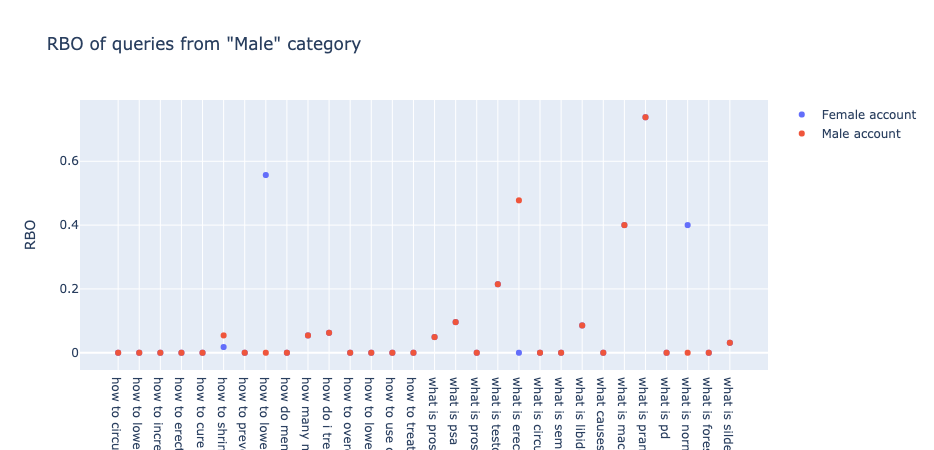

In [331]:
all_queries['rbo_man'] = res_man 
all_queries['rbo_woman'] = res_woman 
all_queries

layout = go.Layout(
    title=go.layout.Title(
            text='RBO of queries from "Male" category'),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='RBO'))
)

fig = go.Figure(layout=layout)

fig.add_scatter(x=all_queries['Male'], y=all_queries['rbo_woman'], mode='markers', name='Female account')
fig.add_scatter(x=all_queries['Male'], y=all_queries['rbo_man'], mode='markers', name='Male account', )

fig.show()

### 'Female' queries

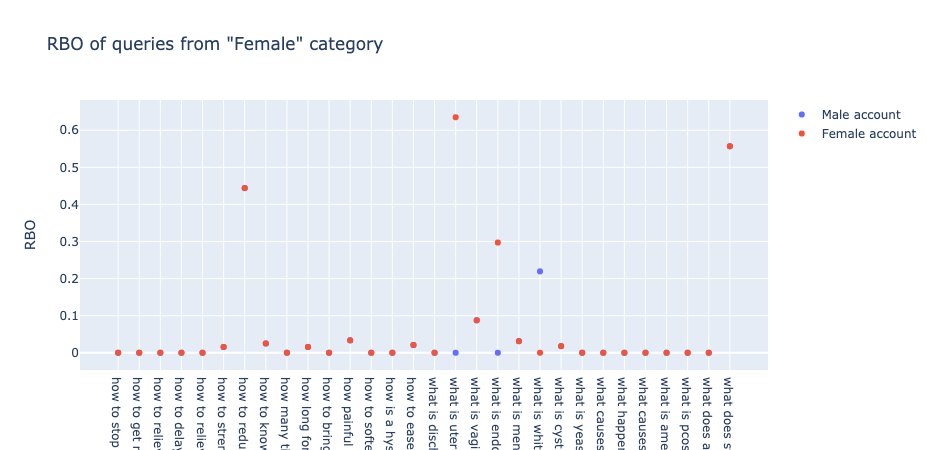

In [347]:
all_queries['rbo_man'] = res_man 
all_queries['rbo_woman'] = res_woman 
all_queries

layout = go.Layout(
    title=go.layout.Title(
            text='RBO of queries from "Female" category'),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='RBO'))
)

fig = go.Figure(layout=layout)

fig.add_scatter(x=all_queries['Female'], y=all_queries['rbo_man'], mode='markers', name='Male account', )
fig.add_scatter(x=all_queries['Female'], y=all_queries['rbo_woman'], mode='markers', name='Female account')


fig.show()

### 'Health' queries

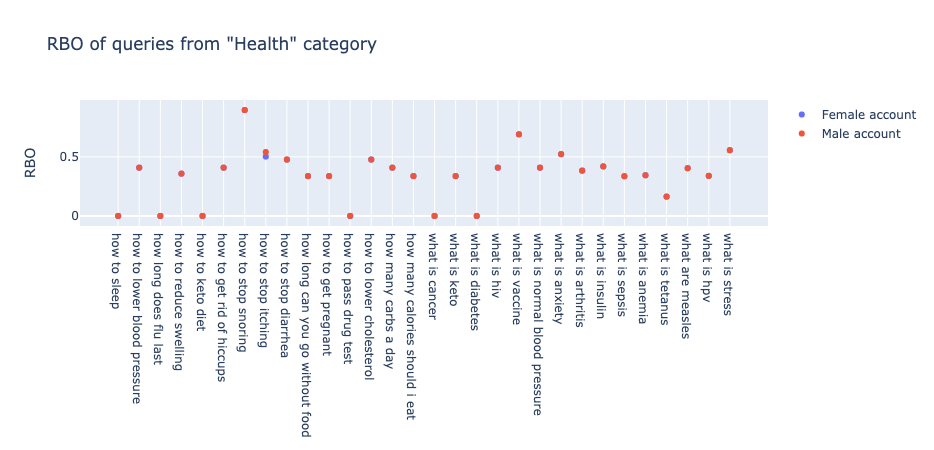

In [368]:
all_queries['rbo_man'] = res_man 
all_queries['rbo_woman'] = res_woman 
all_queries

layout = go.Layout(
    title=go.layout.Title(
            text='RBO of queries from "Health" category'),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='RBO'))
)

fig = go.Figure(layout=layout)

fig.add_scatter(x=all_queries['Health'], y=all_queries['rbo_woman'], mode='markers', name='Female account')
fig.add_scatter(x=all_queries['Health'], y=all_queries['rbo_man'], mode='markers', name='Male account', )

fig.show()

### 'Pharmacy' queries

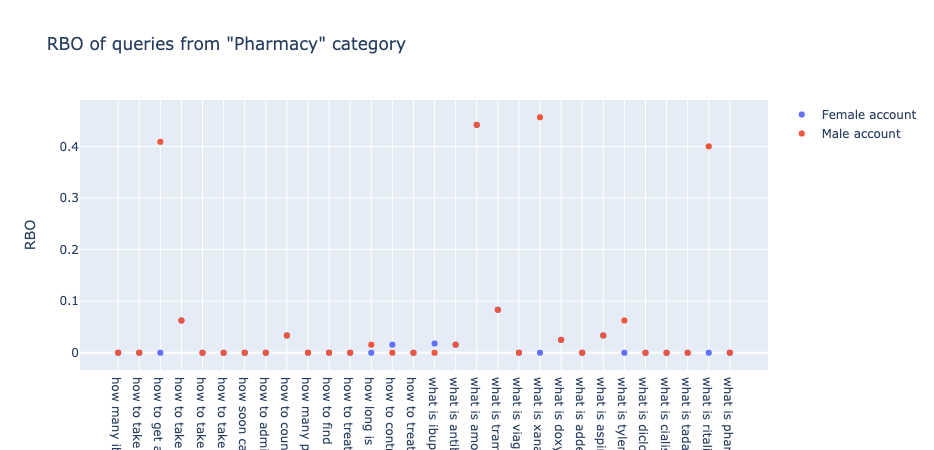

In [339]:
all_queries['rbo_man'] = res_man 
all_queries['rbo_woman'] = res_woman 
all_queries

layout = go.Layout(
    title=go.layout.Title(
            text='RBO of queries from "Pharmacy" category'),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='RBO'))
)

fig = go.Figure(layout=layout)

fig.add_scatter(x=all_queries['Pharmacy'], y=all_queries['rbo_woman'], mode='markers', name='Female account')
fig.add_scatter(x=all_queries['Pharmacy'], y=all_queries['rbo_man'], mode='markers', name='Male account', )

fig.show()

In [110]:
# look only at domain of the URLs
# for i, url in enumerate(G):
#     G[i] = re.search('https?://([A-Za-z_0-9.-]+).*', G[i]).group(1)
    

### Fairness analysis

In [374]:
logout_google_male = pd.read_csv('../Results/Logout/GoogleMale.csv', sep=',') 
logout_hon_male = pd.read_csv('../Results/Logout/HonMale.csv', sep=',') 

man_google_male = pd.read_csv('../Results/Login/Man/GoogleMale.csv', sep=',')
man_hon_male = pd.read_csv('../Results/Login/Man/HonMale.csv', sep=',') 

woman_google_male = pd.read_csv('../Results/Login/Woman/GoogleMale.csv', sep=',') 
woman_hon_male = pd.read_csv('../Results/Login/Woman/HonMale.csv', sep=',') 

all_queries = pd.read_csv('../Data/queries2019_30_4.csv', sep=';')

In [375]:
# maybe add HON here?
res_logout = []
res_man = []
res_woman = []

for query in all_queries.Male:
    
    logout = list(OrderedDict.fromkeys([x for x in logout_google_male.loc[:,query] if str(x) != 'nan']))
    logout_hon = list(OrderedDict.fromkeys([x for x in logout_hon_male.loc[:,query] if str(x) != 'nan']))

    man = list(OrderedDict.fromkeys([x for x in man_google_male.loc[:,query] if str(x) != 'nan']))
    man_hon = list(OrderedDict.fromkeys([x for x in man_hon_male.loc[:,query] if str(x) != 'nan']))

    woman = list(OrderedDict.fromkeys([x for x in woman_google_male.loc[:,query] if str(x) != 'nan']))
    woman_hon = list(OrderedDict.fromkeys([x for x in woman_hon_male.loc[:,query] if str(x) != 'nan']))
    
    # differences in search result because of personalization
    res_logout.append(1 - RBO(logout_hon, logout)) 
    res_man.append(1 - RBO(man_hon, man)) 
    res_woman.append(1 - RBO(woman_hon, woman)) 
    
print(res_logout)
print(res_man)
print(res_woman)

[0.5995535714285715, 0.39747023809523807, 0.21175595238095235, 0.6266369047619048, 0.5202380952380953, 0.5705357142857144, 0.9665178571428571, 0.7986607142857143, 0.7066964285714286, 0.5452380952380953, 0.41309523809523807, 0.5162202380952381, 0.3171130952380953, 0.8477678571428572, 0.7372023809523809, 0.5080357142857144, 0.855952380952381, 0.8351190476190476, 0.5080357142857144, 0.49538690476190483, 0.6181547619047619, 0.8142857142857143, 0.5075892857142857, 0.2869047619047619, 0.3388888888888889, 1.0, 0.984375, 0.6035714285714286, 0.9206845238095238, 0.3431547619047619]
[0.5995535714285715, 0.39747023809523807, 0.21175595238095235, 0.6266369047619048, 0.5202380952380953, 0.5705357142857144, 0.9665178571428571, 0.7986607142857143, 0.7066964285714286, 1, 0.35059523809523807, 0.5162202380952381, 0.3171130952380953, 0.8477678571428572, 0.7372023809523809, 0.5080357142857144, 0.840327380952381, 0.8351190476190476, 0.4391369047619048, 0.5724702380952381, 0.6181547619047619, 0.8142857142857

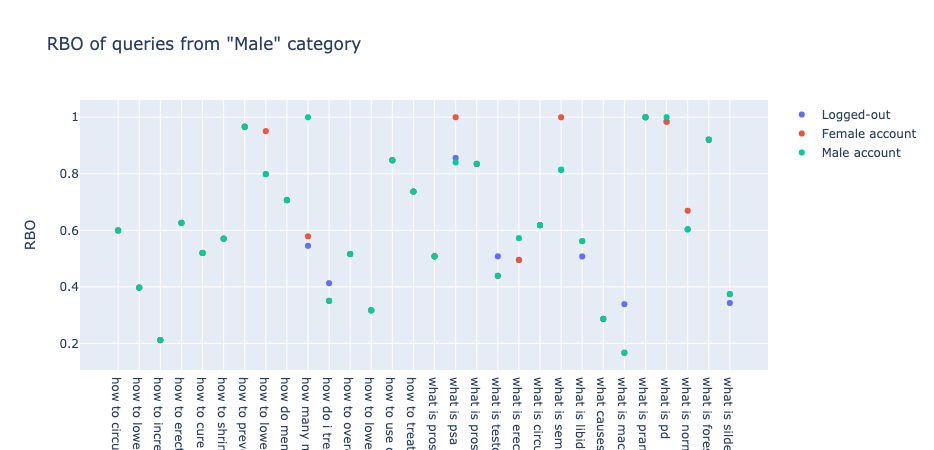

In [376]:
all_queries['rbo_logout'] = res_logout 
all_queries['rbo_man'] = res_man 
all_queries['rbo_woman'] = res_woman 
all_queries

layout = go.Layout(
    title=go.layout.Title(
            text='RBO of queries from "Male" category'),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='RBO'))
)

fig = go.Figure(layout=layout)

fig.add_scatter(x=all_queries['Male'], y=all_queries['rbo_logout'], mode='markers', name='Logged-out', )
fig.add_scatter(x=all_queries['Male'], y=all_queries['rbo_woman'], mode='markers', name='Female account')
fig.add_scatter(x=all_queries['Male'], y=all_queries['rbo_man'], mode='markers', name='Male account', )


fig.show()